In [1]:
from time import time

import numpy as np

import keras
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

plt.style.use('default')
%config InlineBackend.figure_format='retina'

tfd = tfp.distributions
tfb = tfp.bijectors

### Create Data

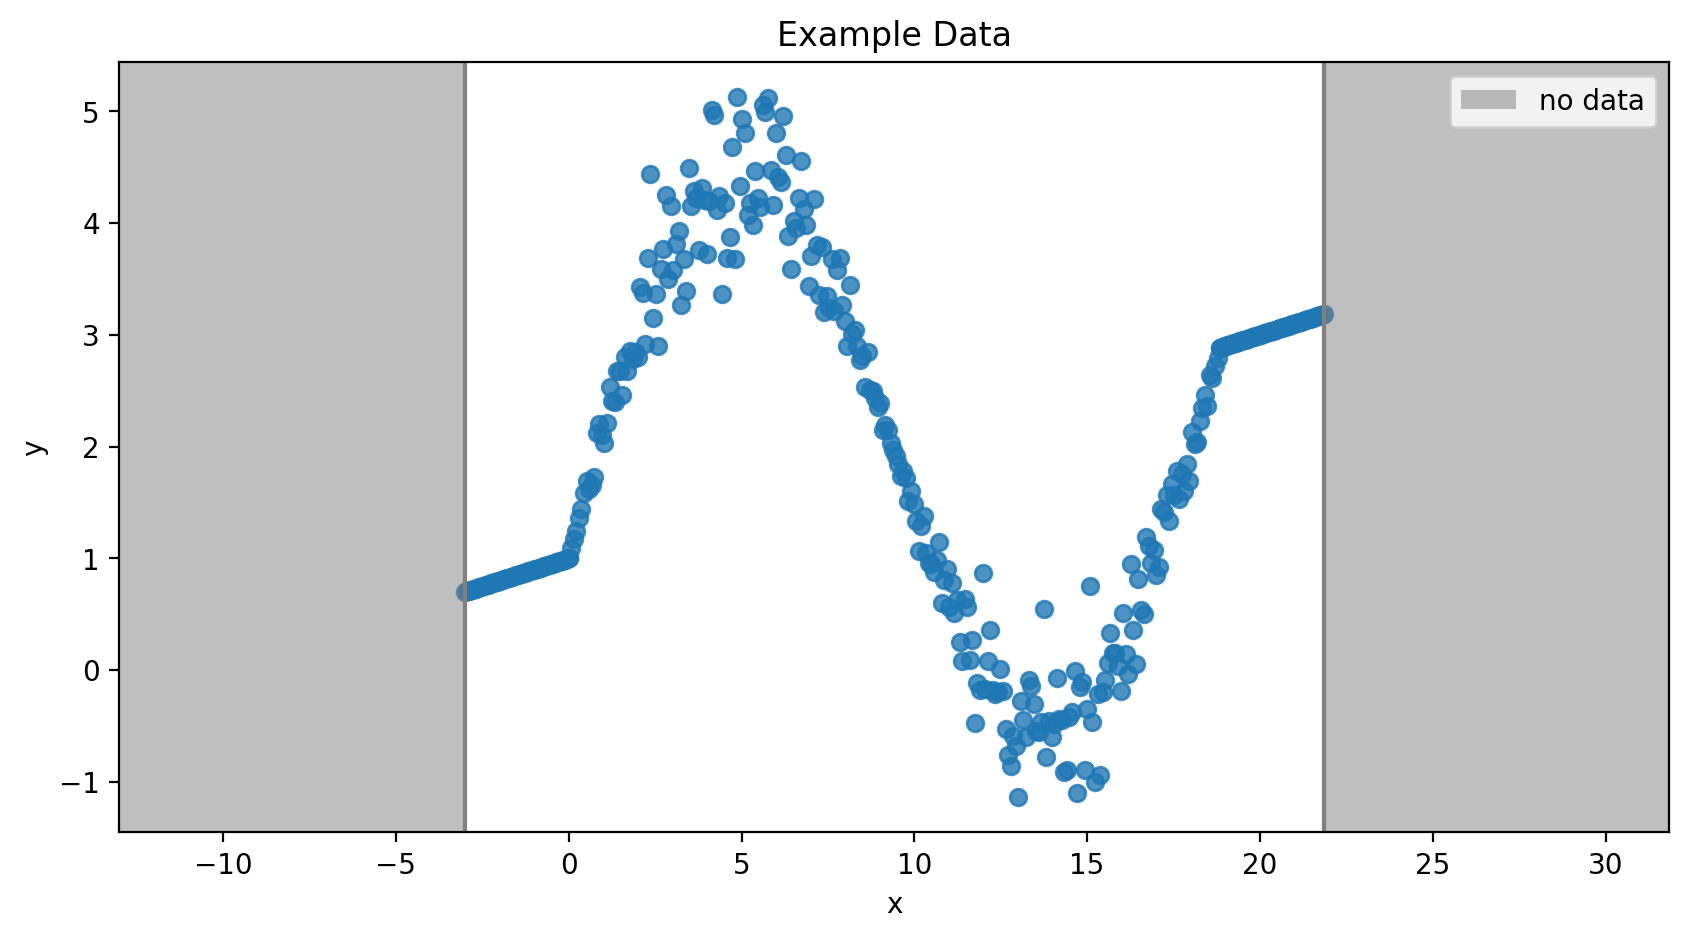

In [46]:

def create_sin_data(n = 2048):
    np.random.seed(32)
    x = np.linspace(0, 1 * 2 * np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate(
        (
            np.zeros(60), 
            y1 + np.random.normal(0,0.15 * np.abs(y1), n),
            np.zeros(60)
        )
    )
    x = np.concatenate(
        (
            np.linspace(-3, 0, 60),
            np.linspace(0, 3 * 2 * np.pi, n),
            np.linspace(3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)
        )
    )
    y2 = 0.1 * x + 1
    y = y1 + y2
    return x, y

x, y = create_sin_data(256) 
x_space_min = x.min() - 10
x_space_max = x.max() + 10

def plot_observed_data(x, y):
    plt.figure(figsize=(10, 5))
    plt.scatter(x=x, y=y, alpha=0.8)
    plt.xlim(x_space_min, x_space_max)
    plt.axvline(x.min(), color='grey')
    plt.axvspan(x_space_min, x.min(), color='grey', alpha=0.5, lw=0)
    plt.axvline(x.max(), color='grey')
    plt.axvspan(x.max(), x_space_max, color='grey', alpha=0.5, lw=0, label='no data')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Example Data")
    plt.legend()

plot_observed_data(x, y)

In [27]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

# TODO: use whatever we are using in our implementation 
def normal_sp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = keras.layers.Input(shape=(1,))
hidden = keras.layers.Dense(20,activation="relu")(inputs)
hidden = keras.layers.Dense(50,activation="relu")(hidden)
hidden = keras.layers.Dense(20,activation="relu")(hidden)
params = keras.layers.Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(normal_sp)(params) 

model_nobay = keras.Model(inputs=inputs, outputs=dist)
model_nobay.compile(keras.optimizers.Adam(), loss=NLL) 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_4 (Dense)             (None, 20)                40        
                                                                 
 dense_5 (Dense)             (None, 50)                1050      
                                                                 
 dense_6 (Dense)             (None, 20)                1020      
                                                                 
 dense_7 (Dense)             (None, 2)                 42        
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                           

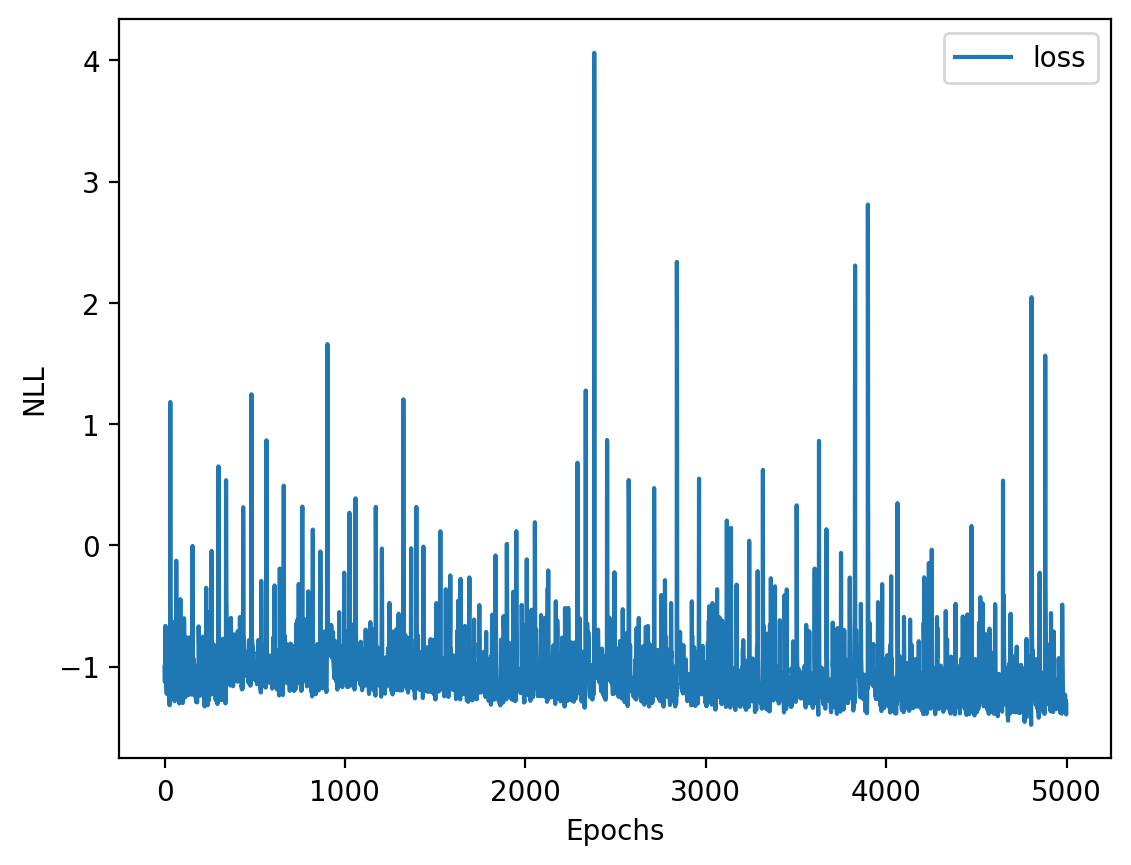

In [84]:
# Train
history = model_nobay.fit(x, y, verbose=0, epochs=5000, batch_size=32)

plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In [85]:
# Predict
x_input_space = np.arange(x_space_min, x_space_max, 0.1) 

runs = 200
nobay_cpd =np.zeros((runs,len(x_input_space)))
for i in range(0, runs):
    predictions = model_nobay.predict(x_input_space, verbose=0)
    nobay_cpd[i,:] = np.reshape(predictions, len(x_input_space))

In [86]:
def plot_learned_distribution(x, num_distributions=1):
    for i in range(0, num_distributions):
        if i == 0:
            plt.plot(x_input_space, nobay_cpd[i, :], color='red', alpha=0.5, zorder=2, label='Learned Function(s)')
        else:
            plt.plot(x_input_space, nobay_cpd[i, :], color='red', alpha=0.5, zorder=2)
        plt.legend()

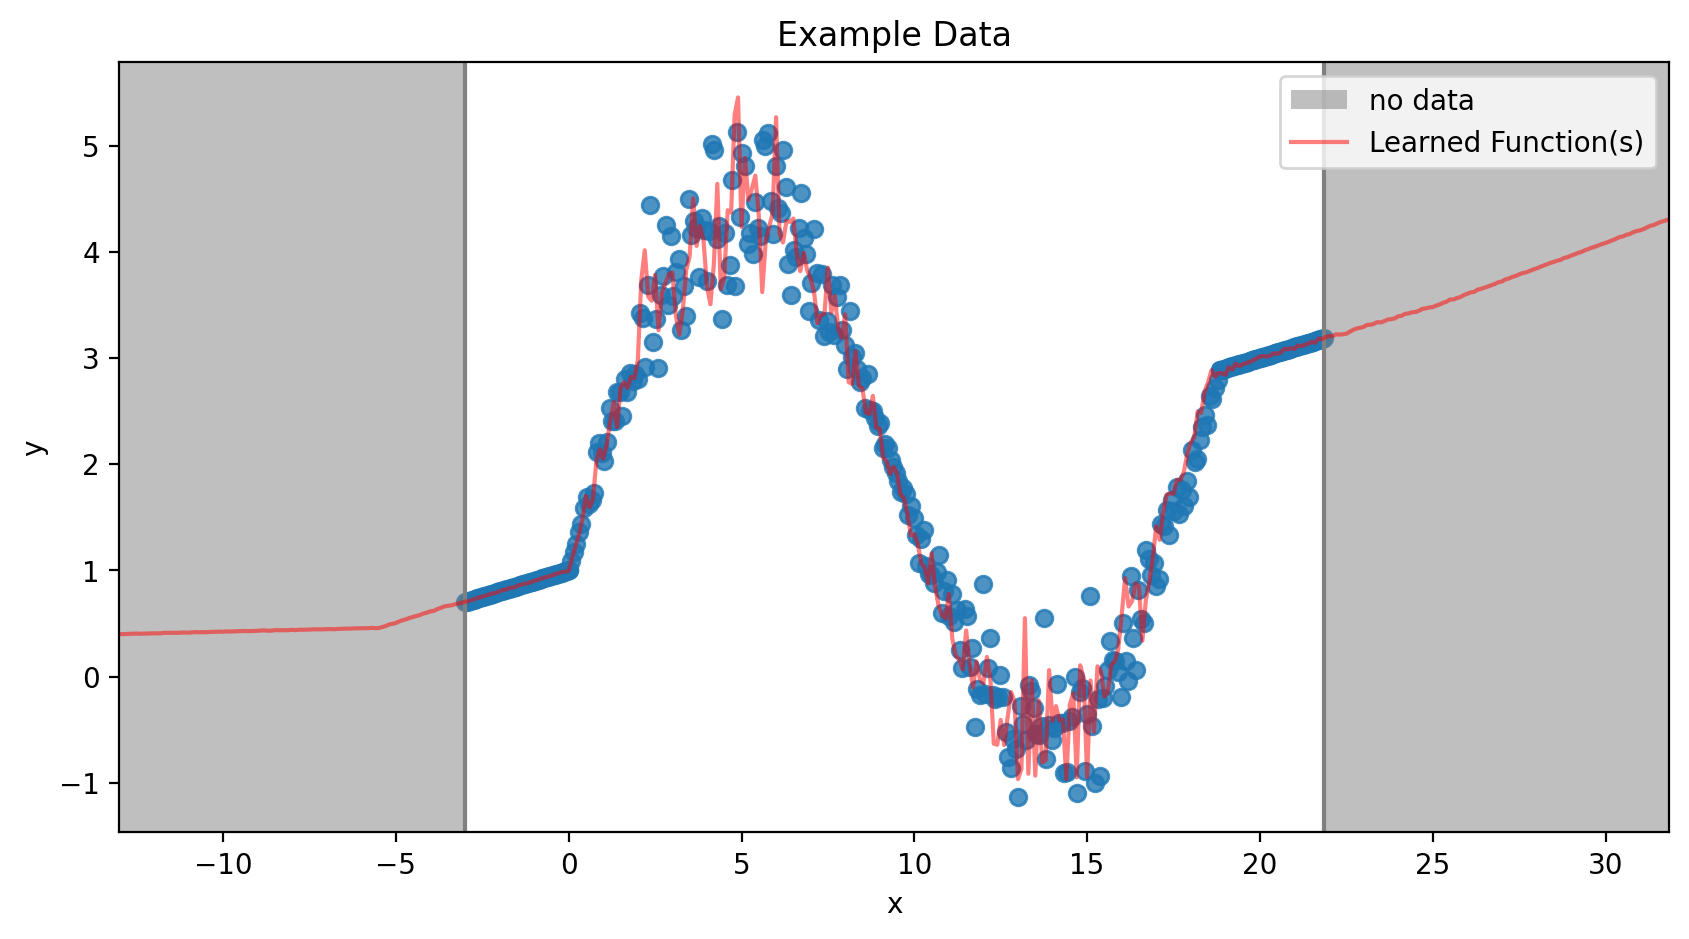

In [87]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=1)

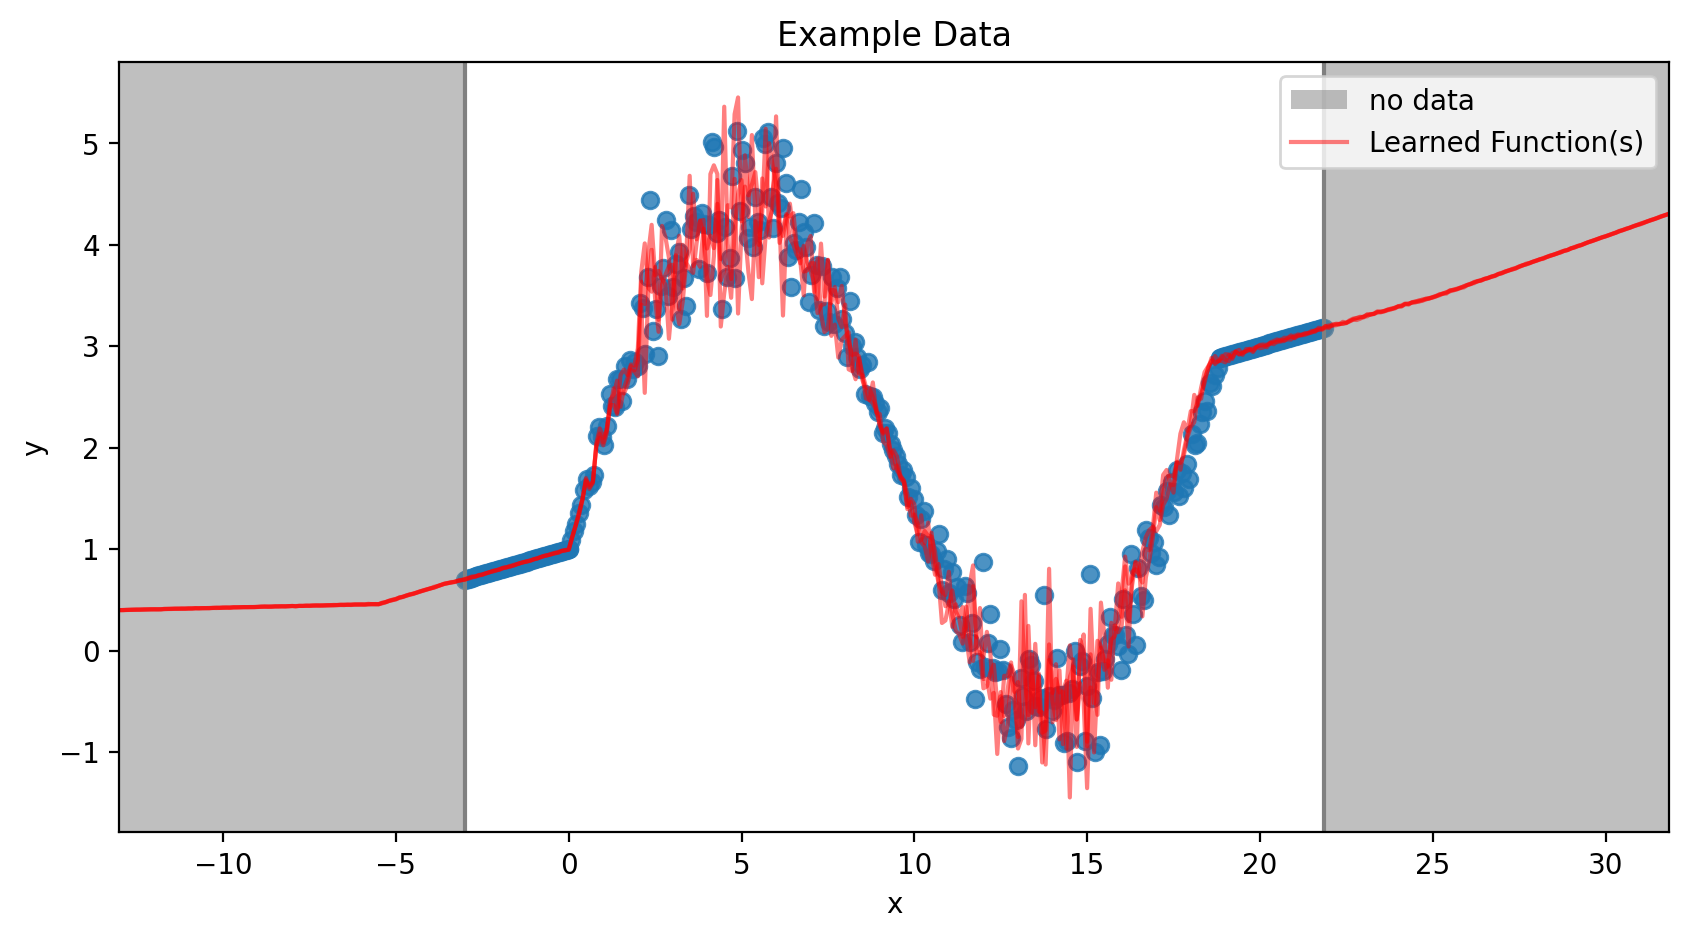

In [88]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=3)

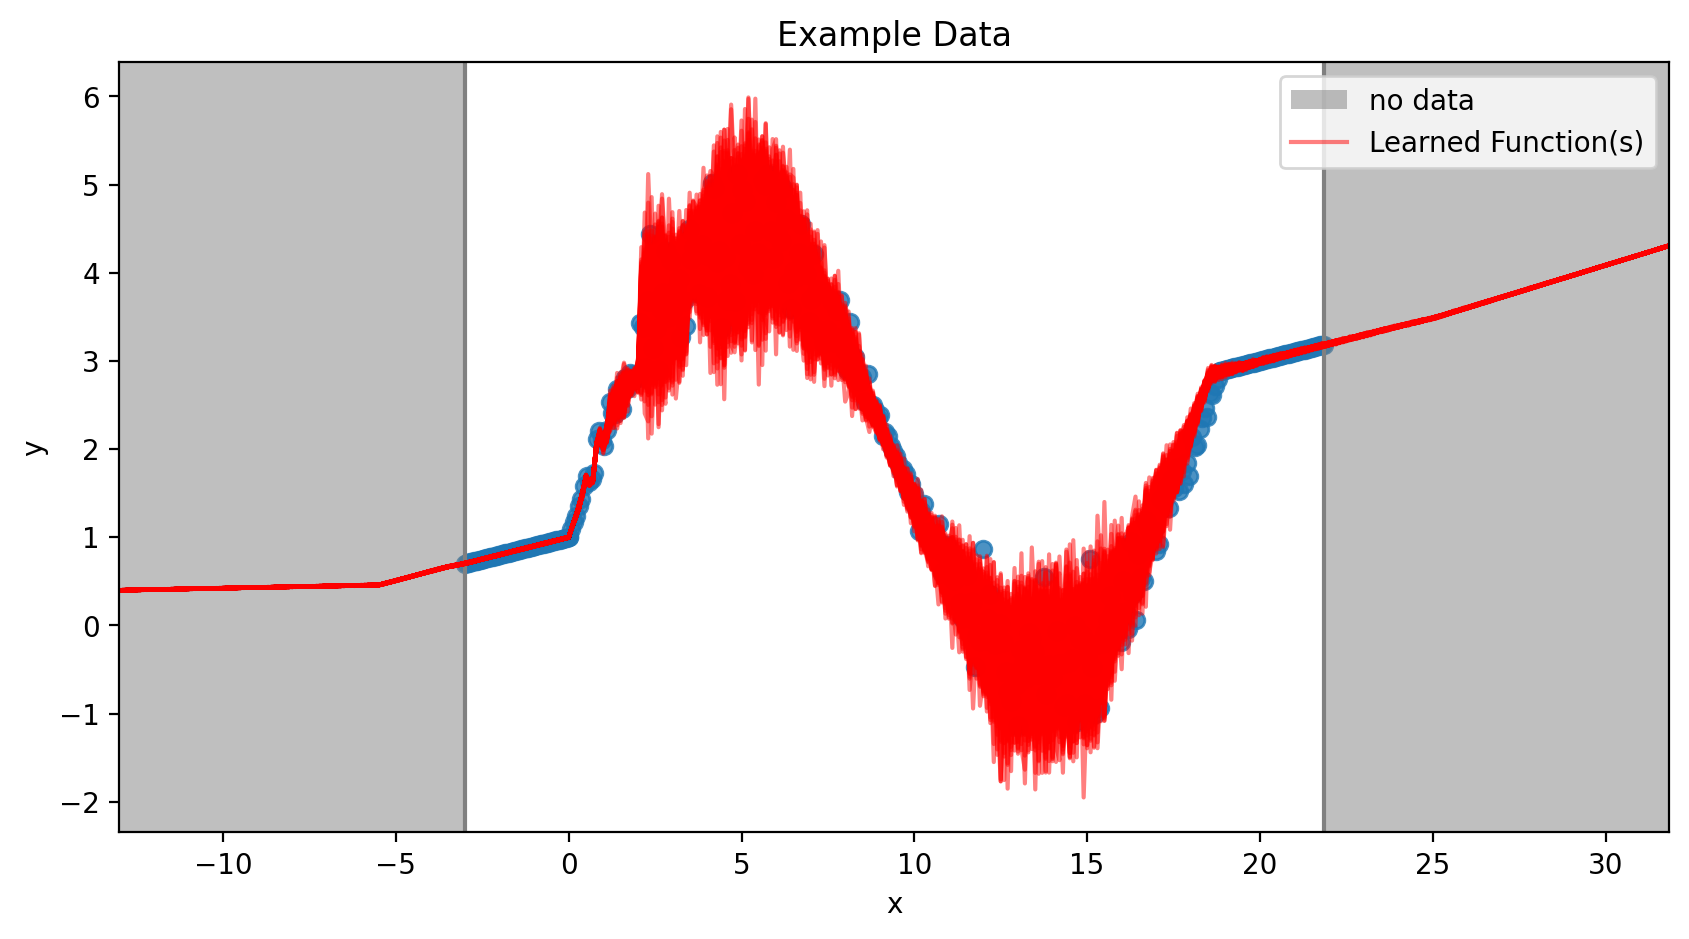

In [89]:
plot_observed_data(x, y)
plot_learned_distribution(nobay_cpd, num_distributions=nobay_cpd.shape[0])

In [94]:
def plot_learned_distribution_average(x):
    # Plot Mean (this is effectively what we would learn if we were just trying to predict a point estimate)
    plt.plot(x_input_space, np.mean(x, axis=0), color="black",linewidth=3, label='mean')

    # Plot confidence bounds (capturing aleatoric uncertainty)
    lower_bound = np.quantile(x, 0.025, axis=0)
    upper_bound = np.quantile(x, 0.975, axis=0)
    plt.plot(x_input_space, lower_bound, color="red",linewidth=1.5,linestyle="--", label='lower bound (2.5%)')
    plt.plot(x_input_space, upper_bound, color="red",linewidth=1.5,linestyle="--", label='upper bound (97.5%)')
    plt.fill_between(x_input_space, lower_bound, upper_bound, color='red', alpha=0.2)

    plt.legend()


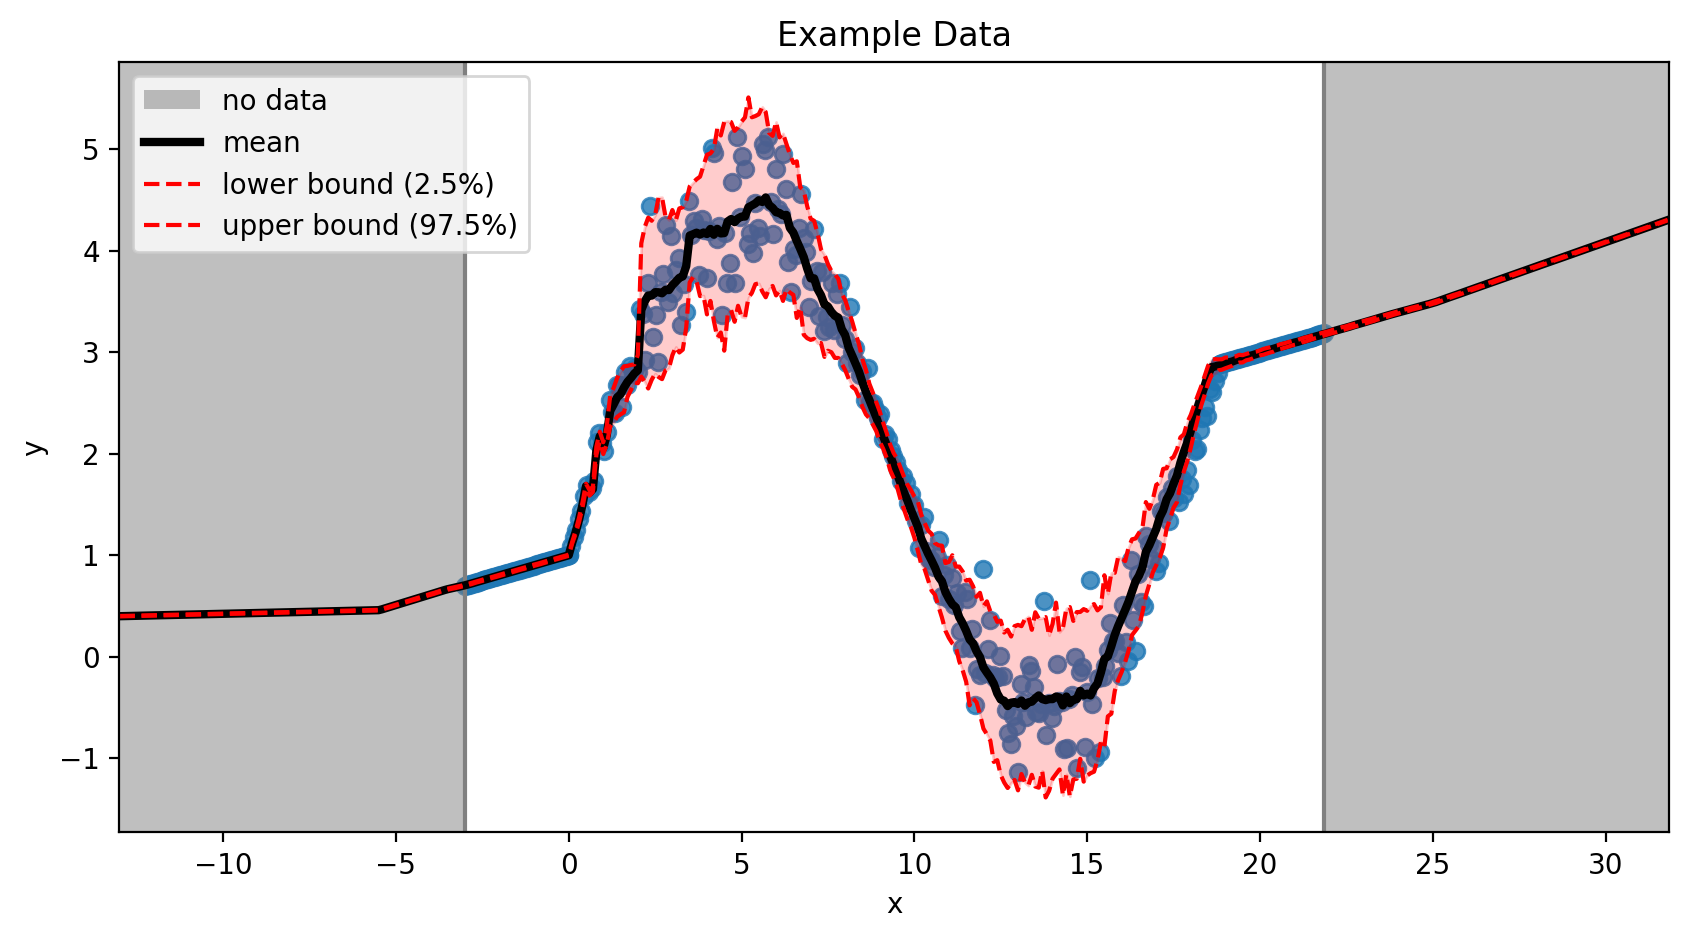

In [95]:
plot_observed_data(x, y)
plot_learned_distribution_average(nobay_cpd)

We see that in the region of **no data** our confidence bounds are incredibly tight. This is the exact opposite behavior of what we would like. Let's improve upon that.

### Variational Inference Model

In [98]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = keras.layers.Input(shape=(1,))

hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
)(inputs)

hidden = tfp.layers.DenseFlipout(
    50,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
)(hidden)

hidden = tfp.layers.DenseFlipout(
    20,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,activation="relu"
    )(hidden)

params = tfp.layers.DenseFlipout(
    2,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn
)(hidden)

dist = tfp.layers.DistributionLambda(normal_sp)(params) 


model_vi = keras.Model(inputs=inputs, outputs=dist)
model_vi.compile(keras.optimizers.Adam(learning_rate=0.0002), loss=NLL) 

model_params = keras.Model(inputs=inputs, outputs=params)

/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nathanieldake/development/intuitiveml/venv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


time taken :  43.979


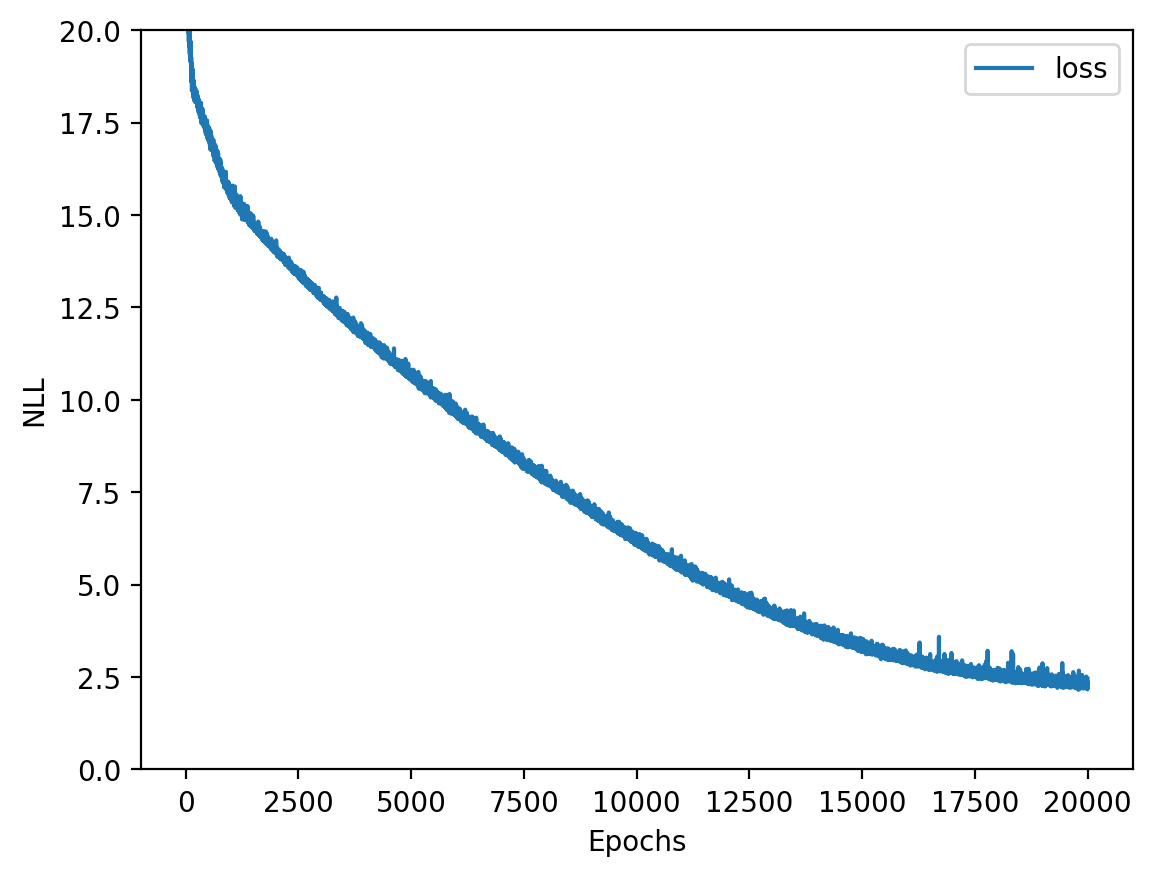

In [99]:

start = time()

history = model_vi.fit(x, y, epochs=20000, verbose=0, batch_size=512)
print('time taken : ',np.round(time() - start,3)) #468 sec
model_vi.save_weights('model_vi.hdf5')
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])

plt.show()

In [106]:
vi_cpd = np.zeros((runs,len(x_input_space)))
for i in range(0, runs):
    vi_cpd[i,:] = np.reshape(model_vi.predict(x_input_space, verbose=0),len(x_input_space))

In [103]:
runs = 200
cpd = np.zeros((runs,len(x_pred)))
mean = np.zeros((runs,len(x_pred)))
std = np.zeros((runs,len(x_pred)))

for i in range(0,runs):
    cpd[i,:] = np.reshape(model_vi.predict(x_pred, verbose=0),len(x_pred))
    mean[i,:] = np.reshape(model_vi(x_pred).mean(), len(x_pred))
    std[i,:] = np.reshape(model_vi(x_pred).stddev(), len(x_pred))


 # No data here - the standard deviation of our learned standard deviations is HIGH! The confidence bounds on our learned standard deviation are WIDE!
print(std[:, 0].mean(), std[:, 0].std())
print(f'Confidence bounds: {np.quantile(std[:, 0], q=0.025)}, {np.quantile(std[:, 0], q=0.975)}')

 # data here - the standard deviation of our learned standard deviations is low! The confidence bounds on our learned standard deviation are SMALL!
print(std[:, 50].mean(), std[:, 50].std())
print(f'Confidence bounds: {np.quantile(std[:, 50], q=0.025)}, {np.quantile(std[:, 50], q=0.975)}')

# data here - the standard deviation of our learned standard deviations is low! The confidence bounds on our learned standard deviation are SMALL!
print(std[:, 70].mean(), std[:, 70].std()) 
print(f'Confidence bounds: {np.quantile(std[:, 70], q=0.025)}, {np.quantile(std[:, 70], q=0.975)}')

0.9051104226335883 0.5386711507941917
Confidence bounds: 0.2538460649549961, 2.3433029830455787
0.6424720522761345 0.09144837924736911
Confidence bounds: 0.4703469917178154, 0.8512846425175667
0.6697804427146912 0.02499015385728094
Confidence bounds: 0.6271142676472664, 0.725389552116394


In [107]:
print(nobay_cpd.shape)
print(vi_cpd.shape)

(200, 449)
(200, 449)


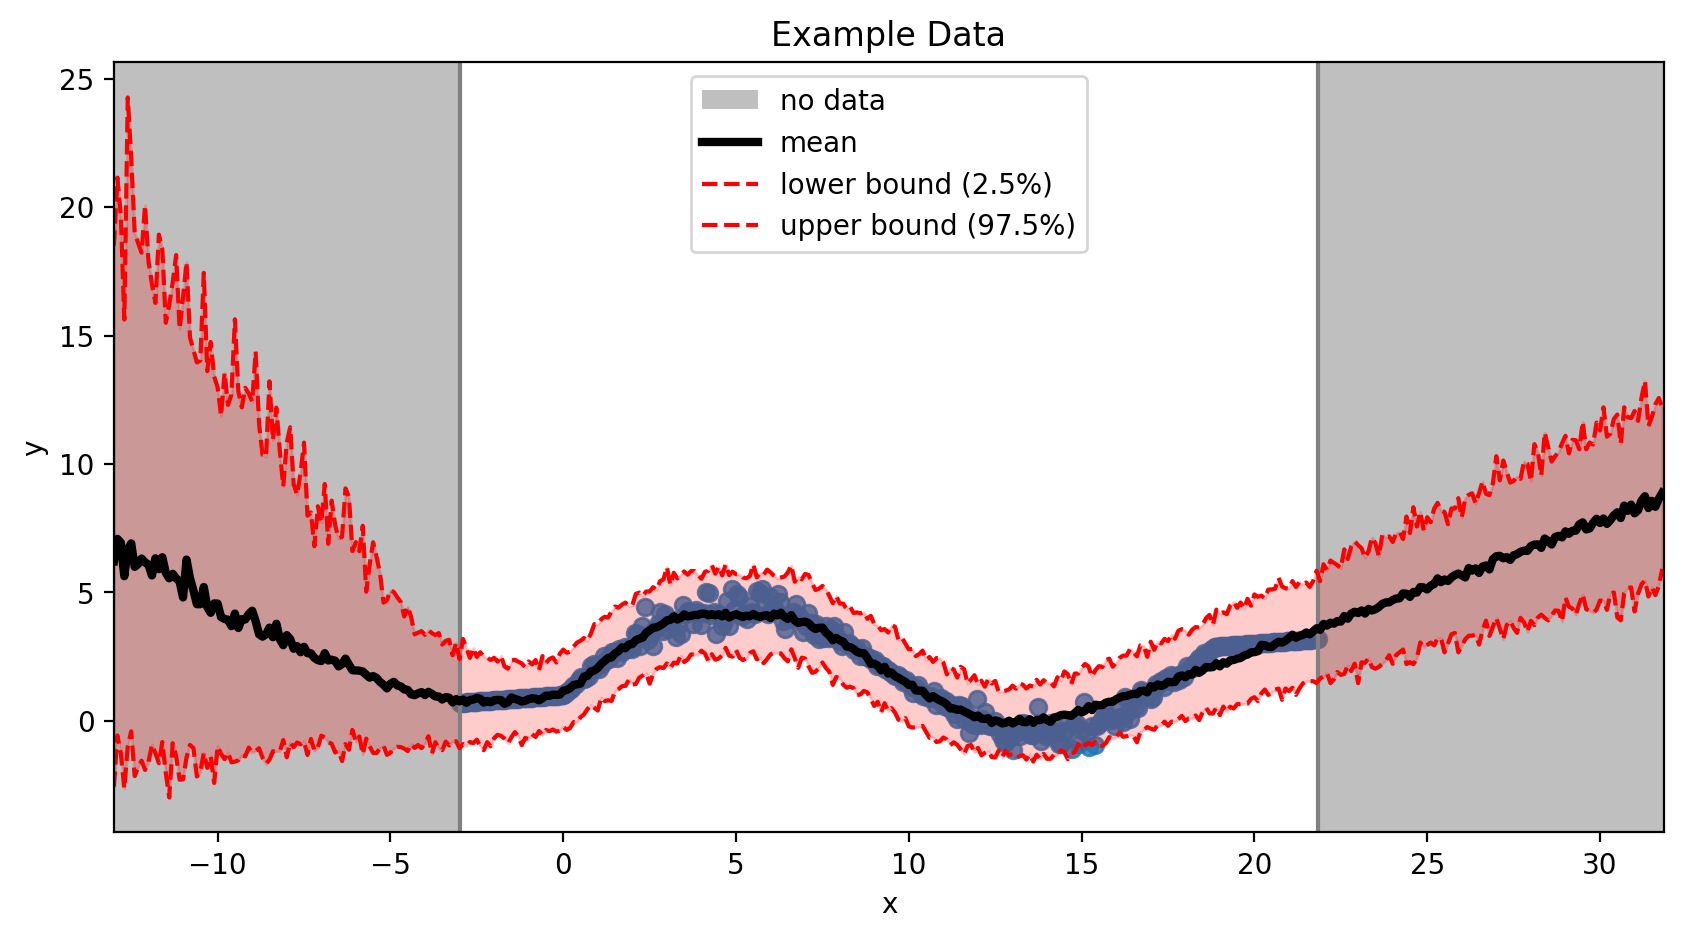

In [108]:

plot_observed_data(x, y)
plot_learned_distribution_average(vi_cpd)

### MC Dropout

In [28]:
from tensorflow.keras.layers import Dropout

def normal_exp(params): 
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable


inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.0002), loss=NLL) 

In [29]:
model_mc.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_8 (Dense)             (None, 200)               400       
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 500)               100500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0   

In [30]:
from time import time
start = time()
# Note that the model has been trained with 2048 data points
history = model_mc.fit(x, y, epochs=1000, verbose=0,batch_size=512)
print('time taken : ',np.round(time() - start,3)) #468 sec
model_vi.save_weights('model_mc.hdf5')
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])
plt.show()

In [143]:
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

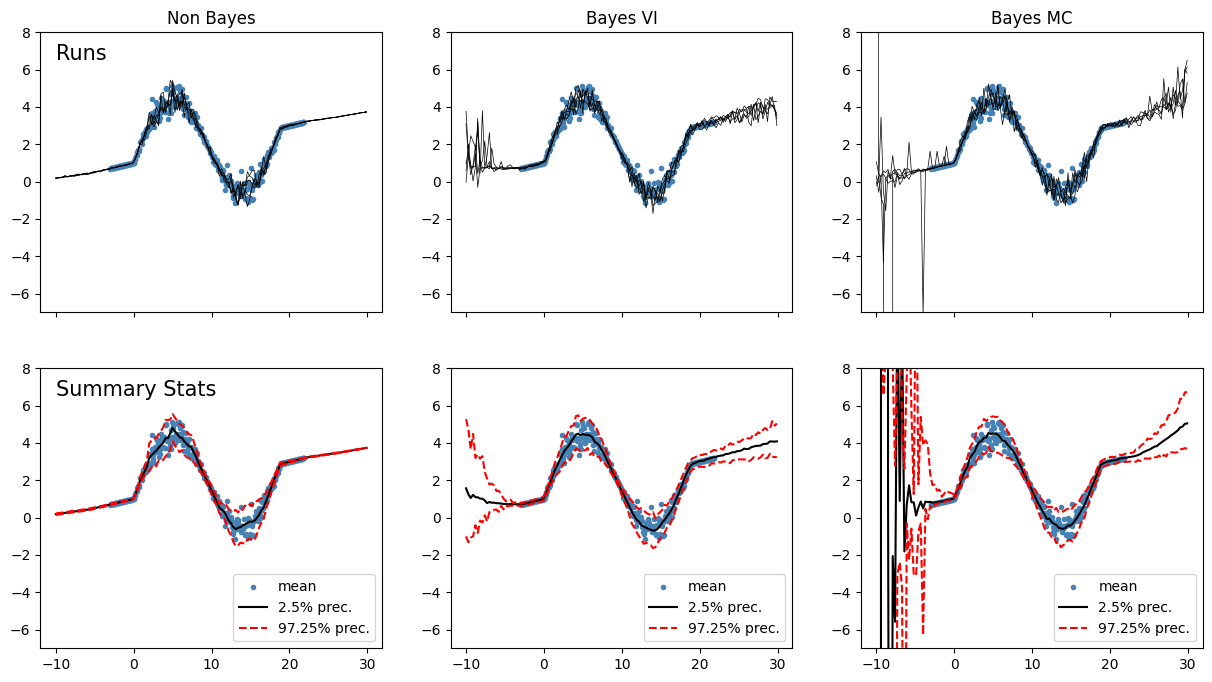

In [33]:
#plt.figure(figsize=(5,25))
f, ax = plt.subplots(2,3,sharex=True, sharey=False,figsize=(15,8))

lines = 5

make_plot_runs(ax[0,0], nobay_cpd[0:lines])
#make_no_bayes_plot(ax[0,1], model_nobay_mean, model_nobay_sd, add_std=False,ylim=[-7,8])
ax[0,0].set_title('Non Bayes')
make_plot_runs_avg(ax[1,0],nobay_cpd)
ax[1,0].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,1].set_title('Bayes VI')
make_plot_runs(ax[0,1], vi_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,1], vi_cpd, ylim=[-7,8])
ax[1,1].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

ax[0,2].set_title('Bayes MC')
make_plot_runs(ax[0,2], mc_cpd[0:lines], ylim=[-7,8])
make_plot_runs_avg(ax[1,2], mc_cpd, ylim=[-7,8])
ax[1,2].legend(('mean','2.5% prec.','97.25% prec.'), loc='lower right')

#ax[0,0].axis('off')
ax[0,0].text(-10,6.5, "Runs",fontsize=15,horizontalalignment='left')

#ax[1,0].axis('off')
ax[1,0].text(-10,6.5, "Summary Stats",fontsize=15,horizontalalignment='left')


# plt.savefig('ch08_good_cpd.pdf')

plt.show()

In [39]:
# model_mc.predict(x_pred).shape

# model_mc(x_pred) # Returns a distribution object!

# model_mc(x_pred).mean()

# model_mc(x_pred).stddev()

# model_mc(x_pred).sample()

<tfp.distributions.Normal 'model_4_normal_exp_Normal' batch_shape=[134, 1] event_shape=[] dtype=float32>